# Dynamics of an elastic beam: explicit time integration
In this notebook, we investigate the dynamics of an elastic beam using a linear and a nonlinear model. The beam is subjected to an external traction at one of its two ends over a short time period. We compute the dynamics of the beam using an explicit time-stepping scheme.


#### Libraries

In [1]:
import dolfin
import numpy as np
import matplotlib.pyplot as plt
import ufl
import time

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["optimize"] = True

In [2]:
use_linear_model = True
use_lumped_mass = False

### Definition of the geometry and the mesh

We consider a cantilever beam of size `Lx × Ly` (2D, plane stress), fixed at its `x = 0` end, and subjected to an axial load at `x = Lx`. 

In [3]:
p1 = dolfin.Point(0., 0.)
p2 = dolfin.Point(1., 0.1)

ny = 10
nx = 10*ny

mesh = dolfin.RectangleMesh(p1, p2, nx, ny)

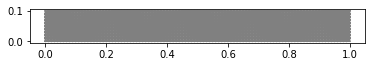

In [4]:
dolfin.plot(mesh)

In [5]:
left  = dolfin.CompiledSubDomain("on_boundary && near(x[0], 0)")
right = dolfin.CompiledSubDomain("on_boundary && near(x[0], L)", L=p2.x())

boundary_indices = {"left": 0, "right": 1}
boundary_markers = dolfin.MeshFunction("size_t", 
                                       mesh    , 
                                       dim=1   , 
                                       value=0 )

left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])

ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Material, loading and time-discretization parameters

A time-dependent traction is applied at the $x = L_x$ face as follows
\begin{equation}
\vec T = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}\vec T_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
\vec 0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [6]:
# Material properties
Y  = 10. # Young modulus
nu = 0.3

mu = dolfin.Constant(Y/(2.*(1.+nu)))
lambda_ = Y*nu/((1.+nu)*(1.-2.*nu))
lambda_ = dolfin.Constant(2*lambda_*mu/(lambda_+2*mu)) # plane-stress ????

rho = dolfin.Constant(1.)

# viscosity/damping
eta_m = dolfin.Constant(0.01)    # a  # in C = a*M + b*K
eta_k = dolfin.Constant(0.00001) # b  # in C = a*M + b*K

# -------------------------------

# Study parameters
t_end = 3.
num_steps  = 5*800
dt = t_end/num_steps

t_cutoff = .1     # tc
traction_max = 1. # T_max = T ??

# -------------------------------

expr = ["0", "t <= t_cutoff ? traction_max*t/t_cutoff : 0"]

traction = dolfin.Expression(expr, t=0, t_cutoff=t_cutoff, traction_max=traction_max, degree=0)

### Definition of the problem in the linear and in the nonlinear case (finite deformations)

In [7]:
V = dolfin.VectorFunctionSpace(mesh, "CG", 1) # continuous lagrangian elements

In [8]:
zero = dolfin.Constant((0, 0))
bc = dolfin.DirichletBC(V, zero, left)

#### Kinematics nonlinear case

In [9]:
I2 = dolfin.Identity(2) # Identity tensor

def stress_nonlinear(u):
    
    """ Function returning non-linear stress base on
    compressible neo-Hookean model, provided u field.
    """
    
    F  = ufl.variable(I2 + ufl.grad(u))
    CC = F.T*F            
    Ic = ufl.tr(CC)
    J  = ufl.det(F)
    E  = 1/2*(CC-I2)

# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)

#    psi = lambda_*ufl.tr(E)**2/2+mu*ufl.inner(E,E) # usual elastic energy density
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2
    
    return ufl.diff(psi, F) 

def energy_nonlinear(u):  

    """ Function returning energy E = W_int - W_ext based on
    compressible neo-Hookean model, provided u field.
    """
    
    F  = ufl.variable(I2 + ufl.grad(u))  
    CC = F.T*F                   
    Ic = ufl.tr(CC)
    J  = ufl.det(F)
    E  = 1/2*(CC-I2)

# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)

#    psi = lambda_*ufl.tr(E)**2/2+mu*ufl.inner(E,E) # usual elastic energy density
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2
    
    return psi*dx

def stiffness_nonlinear(u, v):
    
    """ Function returning energy W_int in 
    E = W_int - W_ext ??? provided u and v fields.
    """
    
    return dolfin.inner(stress_nonlinear(u), dolfin.grad(v))*dx

#### Kinematics linear case

In [10]:
def stress_linear(eps):
    
    """ Function returning linear stress 
    sigma, provided u field.
    """
        
    return lambda_*dolfin.tr(eps)*I2+2.*mu*eps

def strain_displacement(u):
    
    """ Function returning linear strain 
    epsilon, provided u field.
    """
    
    return dolfin.sym(dolfin.grad(u))

def stiffness_linear(u, v):
    
    """ Function returning W_int in 
    E = W_int - W_ext, provided u field.
    """
    
    return dolfin.inner(stress_linear(strain_displacement(u)),
                        strain_displacement(v))*dx                     

In [11]:
# Apply linear or non-linear methods

if use_linear_model:
    stiffness = stiffness_linear
    
else:
    stiffness = stiffness_nonlinear    

def mass(u, v):
    return rho*dolfin.inner(u, v)*dx

def damping(u, v):
    return eta_m*mass(u, v)+eta_k*stiffness_linear(u, v)

def p_ext(u):
    return dolfin.dot(u, traction)*ds(boundary_indices["right"])

In [12]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

M = dolfin.assemble(mass(u, v))

In [13]:
# Compute the sum of the rows of the mass matrix
# Only for the case of a lumped mass matrix == our case

m = mass(u, v)
ones = dolfin.Constant((1.,1.))

M_lumped = dolfin.assemble(dolfin.action(m, ones))
M_lumped_inv = 1./M_lumped.get_local()

In [14]:
bc.apply(M) # apply BC

#### No change needed

In [15]:
u = dolfin.Function(V)
v = dolfin.Function(V)

In [16]:
u_vec = u.vector()
v_vec = v.vector()

In [17]:
vector = dolfin.Vector()
M.init_vector(vector, 1)
    
a_vec = vector

In [18]:
if not use_lumped_mass:
    solver = dolfin.LUSolver(M)

In [19]:
coords_tip = p2.array()[:2]
coords_tip[1] *= 0.5

times      = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip  = np.zeros_like(times)

# Initialisation energies
energies   = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp     = 0
E_elas     = 0
E_ext      = 0

### Explicit time-stepping scheme

In [20]:
# test functions
u_vec.zero()
v_vec.zero()
a_vec.zero()

time_solve = 0.

for n in range(num_steps):
    
    traction.t = (n+1)*dt
    
    f      = dolfin.assemble(     p_ext(    dolfin.TestFunction(V) ) )
    f_int  = dolfin.assemble( stiffness( u, dolfin.TestFunction(V) ) )
    f_damp = dolfin.assemble(   damping( v, dolfin.TestFunction(V) ) )   # f_damp included in int forces
    
    f.axpy(-1., f_int)
    f.axpy(-1., f_damp)    
    
    bc.apply(f)
    
    t1 = time.perf_counter() # count time solving
    if use_lumped_mass:
        a_vec[:] = M_lumped_inv*f[:]        
    else:
        solver.solve(a_vec, f)
    t2 = time.perf_counter() # count time solving
    time_solve += t2-t1      # add to have time loop
    
# Corrector step
    v_vec.axpy(dt, a_vec)
    u_vec.axpy(dt, v_vec)
    
    displ_tip[n+1] = u(coords_tip)[0]
    
    if use_linear_model:
        E_elas = dolfin.assemble(0.5*stiffness(u, u))
    else:
        E_elas = dolfin.assemble(energy_nonlinear(u))
    
    E_kin   = dolfin.assemble(0.5*mass(v, v))
    E_damp += dt*dolfin.assemble(damping(v, v))
    E_tot   = E_elas + E_kin + E_damp # E_tot, not conserved though as E_damp is energy removed from the system
    
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot]) #stock energies for later plot

#### Display position beam's tip

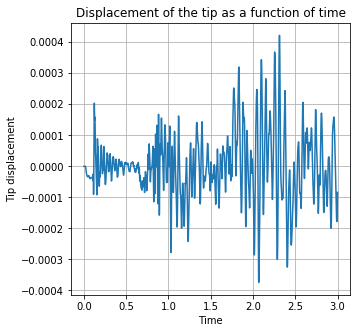

In [21]:
plt.figure(figsize=(5,5))

plt.plot(times, displ_tip, '-')

plt.title('Displacement of the tip as a function of time')
plt.xlabel("Time")
plt.ylabel("Tip displacement")

plt.grid(True)

# plt.savefig("tip_displacement.png")

These big variations are in fact nothing compared to the size of the structure.

With time increasing, we increase vertical force.

#### Display energy variation across time

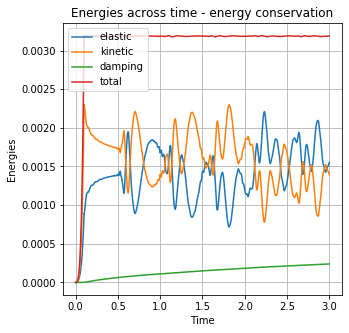

In [22]:
plt.figure(figsize=(5,5))

plt.plot(times, energies)

plt.title('Energies across time - energy conservation')
plt.xlabel("Time")
plt.ylabel("Energies")

plt.grid(True)
plt.legend(("elastic", "kinetic", "damping", "total"))

plt.show()

Energy looks to be conserved. For elasticity and kinetic :
* what is the link ?
* no-explicit shape.

Note that there in fact isn't energy conservation : we here display E_tot = E_kin + E_damp + E_elast.

In [23]:
energies[-1,-1] #total energy of last iteration

0.0031865218916265437

In [24]:
print("Temps de calcul des accélérations {:.2f}s".format(time_solve))

dt_crit = mesh.rmin()/np.sqrt(Y/rho.values())

print("Pas de temps critique {:.2e}s".format(dt_crit[0]))
print("Pas de temps utilisé {:.2e}s".format(dt_crit[0]))

Temps de calcul des accélérations 0.81s
Pas de temps critique 9.26e-04s
Pas de temps utilisé 9.26e-04s


# Exercise

**1)** Change the values of the damping parameters and describe how this modifies the displacement and energy plots. 


**2)** Change the number of time steps and observe what happends when $dt >dt_{crit}$, explain.


**3)** Modify the orientation of the applied traction.


**4)** Do you observe a significant difference when you use the lumped mass matrix instead of the usual mass matrix?


**5)** How does the difference in computational time between these two approaches (lumped mass or standard mass) vary with the size of the mesh?

**6)** Compare the prediction of the linear model with the results obtained with the nonlinear model for the same loading conditions (start with a small applied traction and then try a larger traction). 